In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam


C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages

In [2]:
df= pd.read_csv(r'C:\Users\kdami\Downloads\diabetes - diabetes.csv')

In [3]:
df['Insulin'].to_clipboard()

In [4]:
categorical_features = ['Outcome']
continuous_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
col1, col2 = 'num_of_doors', 'price'
col_group_by = 'body_style'

In [5]:

for column in categorical_features:
  df[column] = df[column].astype('category').cat.codes
for column in continuous_features:
  min = df[column].min()
  max = df[column].max()
  feature_bins = pd.cut(df[column], bins=np.linspace(min, max, 20), labels=False)
  feature_bins = feature_bins.fillna(0)
  df.drop([column], axis=1, inplace=True)
  df = pd.concat([df, feature_bins], axis=1)

In [6]:
df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6.0,14.0,11.0,6.0,0.0,9.0,4.0,9.0
1,0,1.0,8.0,10.0,5.0,0.0,7.0,2.0,3.0
2,1,8.0,17.0,9.0,0.0,0.0,6.0,4.0,3.0
3,0,1.0,8.0,10.0,4.0,2.0,7.0,0.0,0.0
4,1,0.0,13.0,6.0,6.0,3.0,12.0,17.0,3.0


In [7]:
df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

In [8]:
df.shape

(768, 9)

In [9]:
# training configuration
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
# epochs = 5000+1
epochs = 100
learning_rate = 5e-4
models_dir = 'model'




class GAN():

    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size). \
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size). \
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments

        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            ##diff from original - I added steps=1 here after an error stating that the steps arg had to be
            ##explicitly declared. Adding more steps generates more fake data, however the input
            ##DF and the gen_data DF have to have the same number of samples, apparently.
            ##I'm sure there's a way around that limitation, right?
            gen_data = self.generator.predict(noise,steps=1)
            

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                # Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                # Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return

    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator


class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)


class Discriminator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [10]:
target_df = df

In [11]:
data_cols = df.columns

In [12]:
data_cols

Index(['Outcome', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [13]:
df[data_cols] = df[data_cols]

In [14]:
gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]


model = GAN

In [15]:
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 [D loss: 0.688997, acc.: 40.62%] [G loss: 0.676331]
generated_data
1 [D loss: 0.647682, acc.: 50.00%] [G loss: 0.658577]
2 [D loss: 0.632806, acc.: 50.00%] [G loss: 0.624035]
3 [D loss: 0.640917, acc.: 50.00%] [G loss: 0.587423]
4 [D loss: 0.643322, acc.: 50.00%] [G loss: 0.601935]
5 [D loss: 0.605867, acc.: 50.00%] [G loss: 0.657907]
6 [D loss: 0.572858, acc.: 51.56%] [G loss: 0.787007]
7 [D loss: 0.529098, acc.: 71.88%] [G loss: 0.879106]
8 [D loss: 0.568510, acc.: 57.81%] [G loss: 0.884508]
9 [D loss: 0.585409, acc.: 53.12%] [G loss: 0.882602]
10 [D loss: 0.641485, acc.: 42.19%] [G loss: 0.923523]
11 [D loss: 0.599340, acc.: 50.00%] [G loss: 1.018114]
12 [D loss: 0.592147, acc.: 68.75%] [G loss: 1.142447]
13 [D loss: 0.565775, acc.: 81.25%] [G loss: 1.222932]
14 [D loss: 0

In [16]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 32)]                0         
_________________________________________________________________
dense (Dense)                multiple                  4224      
_________________________________________________________________
dense_1 (Dense)              multiple                  33024     
_________________________________________________________________
dense_2 (Dense)              multiple                  131584    
_________________________________________________________________
dense_3 (Dense)              multiple                  4617      
Total params: 173,449
Trainable params: 173,449
Non-trainable params: 0
_________________________________________________________________


In [17]:
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 9)]                 0         
_________________________________________________________________
dense_4 (Dense)              multiple                  5120      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  131328    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  32896     
_________________________________________________________________
dense_7 (Dense)              multiple                  129 

In [18]:
synthesizer.save(r'C:\Users\kdami\Mar21-synthetic-data\notebooks\model', 'diabetes_patients')

In [33]:


# Setup parameters visualization parameters
seed = 17
test_size = 768 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']

col1, col2 = 'Glucose', 'Insulin'

base_dir = 'model/'


In [34]:
models = {'GAN': ['GAN', False, synthesizer.generator]}


In [35]:
[model_name, with_class, generator_model] = models['GAN']
generator_model.load_weights( base_dir + '_generator_model_weights_step_0.h5')

In [36]:
g_z = generator_model.predict(z)

In [41]:
gen_df= pd.DataFrame(g_z, columns= data_cols)

768 768


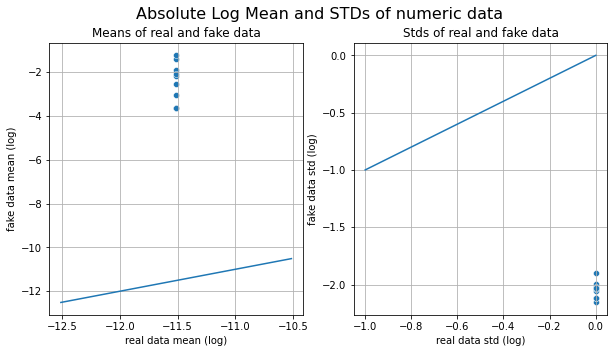

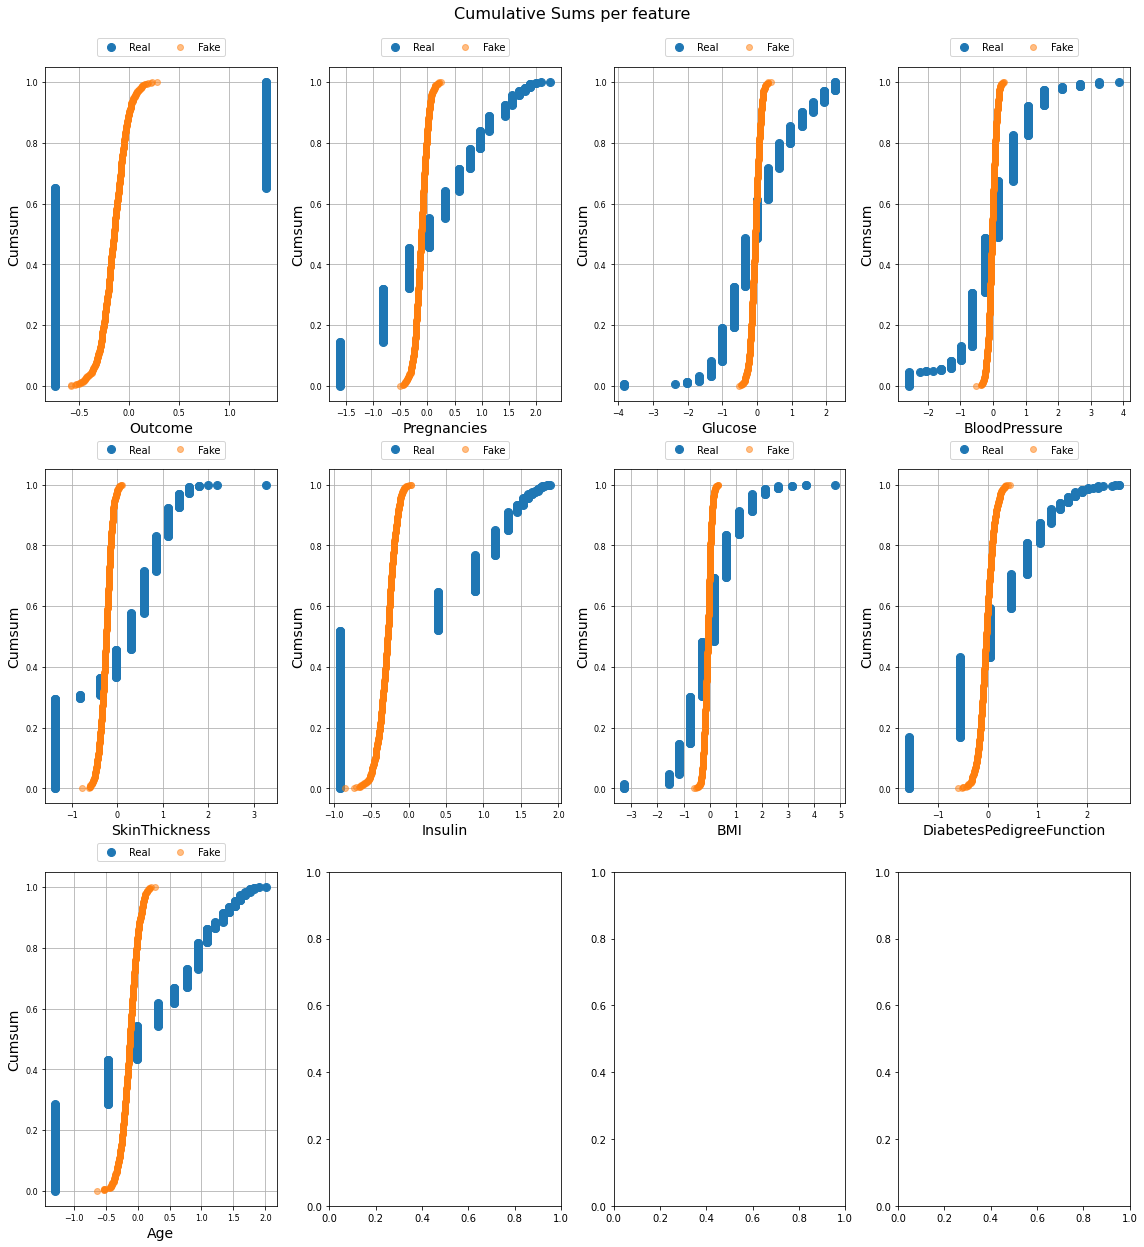

C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kdami\Anaconda2\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

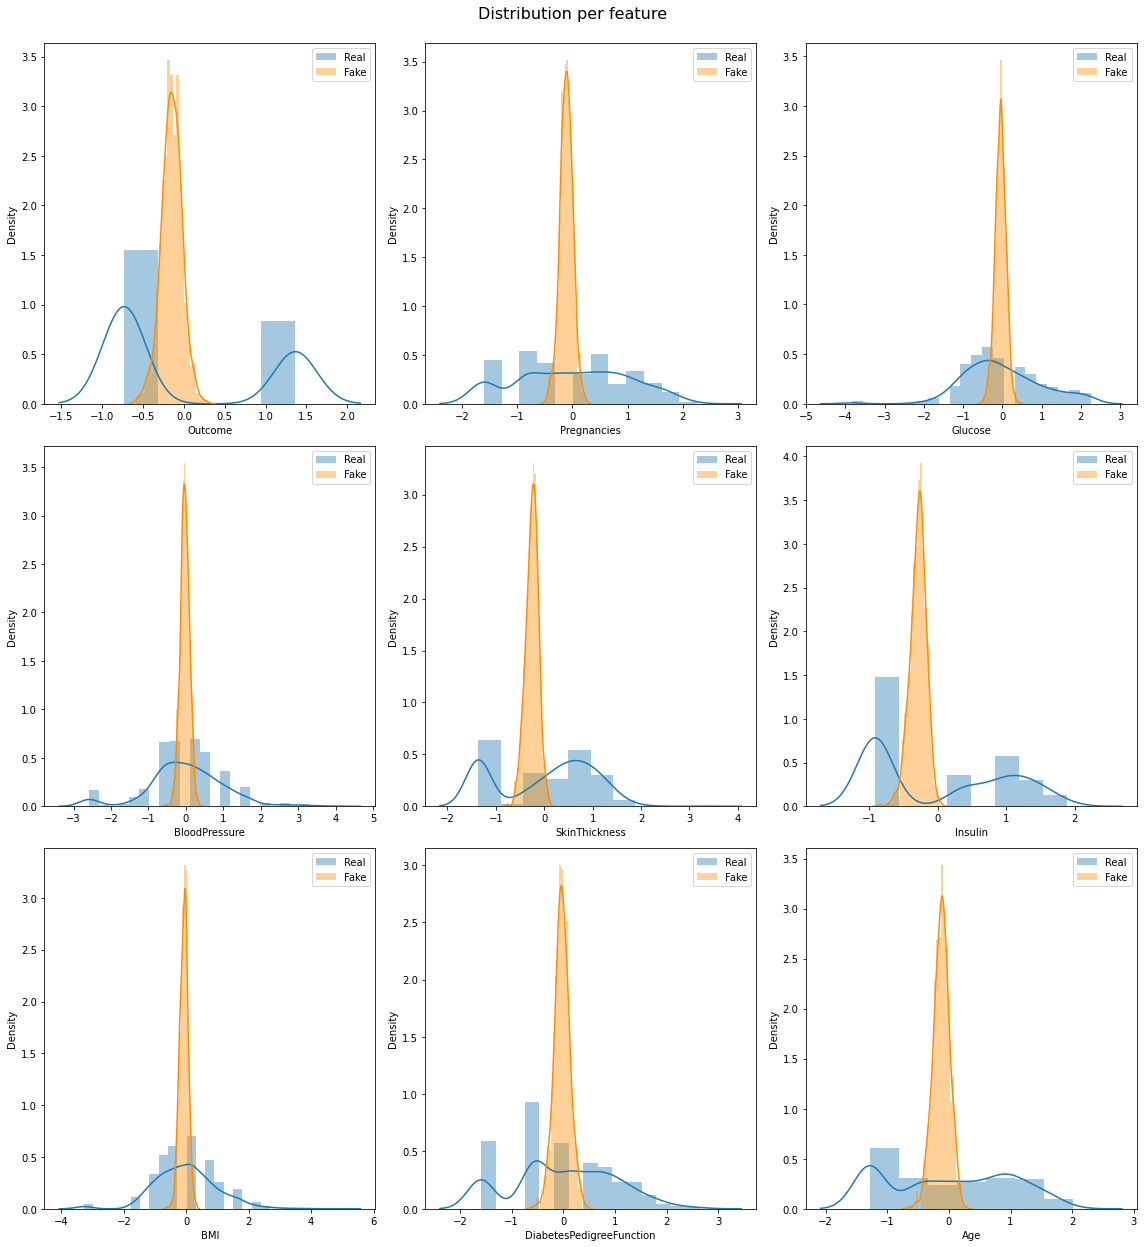

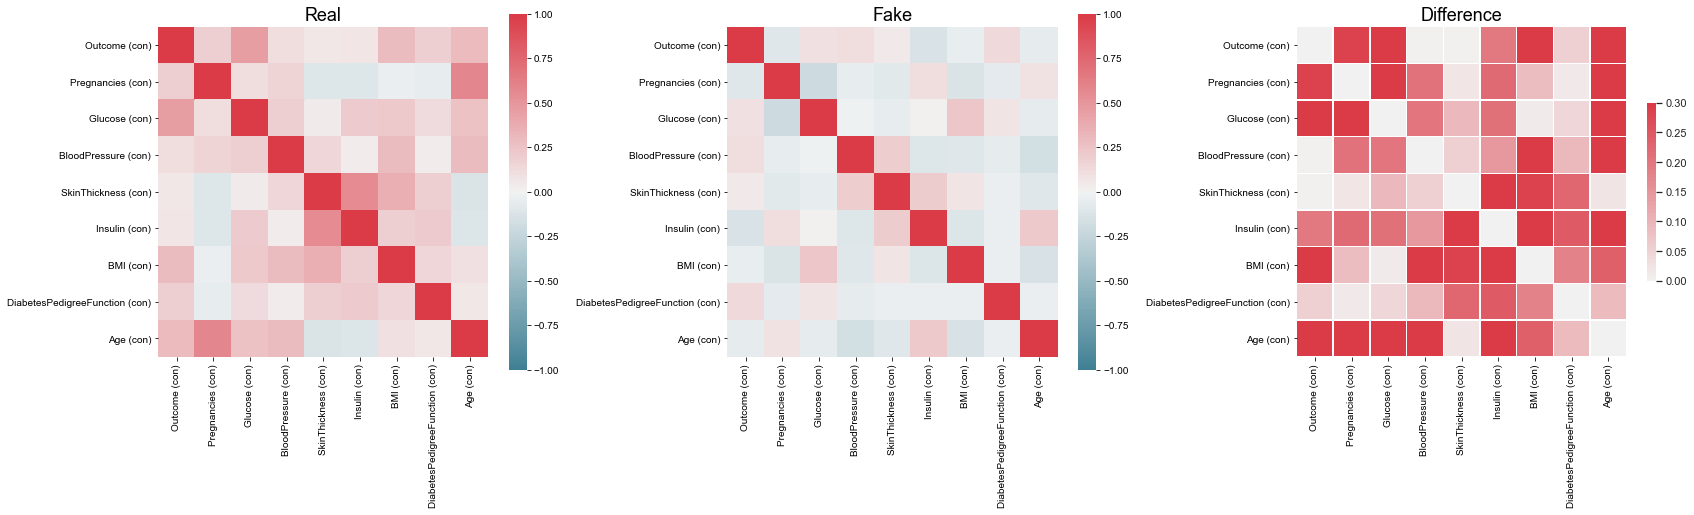

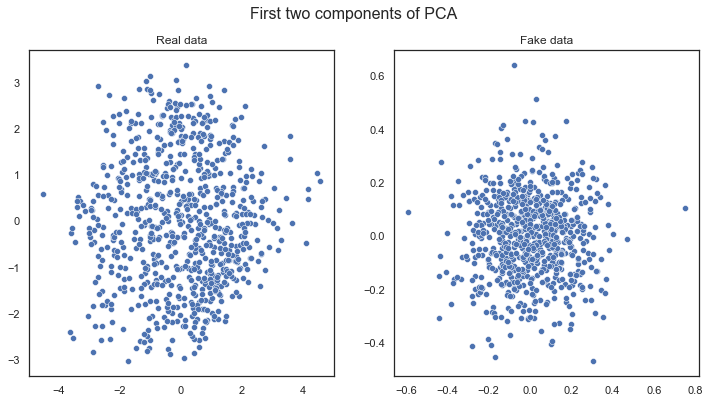

In [44]:
from table_evaluator import load_data, TableEvaluator


print(len(df), len(gen_df))
table_evaluator =  TableEvaluator(df, gen_df)

table_evaluator.visual_evaluation()